### Chapter Outline:
    1. Recap
    2. Chapter Goals
    3. Expectation-Maximization walkthrough
    4. GMM application
    5. Choosing Number of Components
    6. GMM exploration
    7. Conclusions

In [1]:
%load_ext watermark
%watermark

from IPython.display import display

# import standard libs
from pathlib import PurePath, Path
import sys
import time

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
script_dir = pdir / 'scripts' 
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
import math

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

# set plot globals
plt.style.use('bmh') #
#plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,8
#plt.rcParams['axes.facecolor'] = sns.xkcd_rgb['gunmetal']

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine,pyarrow

2017-12-05T09:56:59-07:00

CPython 3.6.2
IPython 6.1.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.10.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


/home/bcr/anaconda3/envs/bayesian/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



pandas 0.21.0
pandas_datareader 0.5.0
numpy 1.13.1
sklearn 0.19.0
statsmodels 0.8.0
scipy 1.0.0
matplotlib 2.1.0
seaborn 0.8.1
plotnine 0.3.0+9.g6519baa
pyarrow 0.7.1


## 1. Recap

In the last chapter we went through some foundational concepts. 

We discussed stationarity, why it is important, and its rules. We were able to understand the concept by thoroughly examining the most common ways that financial time series violate the requirements. 

We illustrated how financial time series have trends _(means vary with time)_, changing volatility _(variance changes with time)_, clustering volatility _(autocorrelation between t and t+i)_.

Using statistical techniques we demonstrated that asset returns from different time periods and scales appear to come from different distributions.

We concluded that for our purposes of predicting future return distributions, techniques that cannot accomodate the time varying properties of financial asset returns are a danger to our trading acocunts.

## 2. Chapter Goals

In this chapter we will see how Gaussian Mixture Models (gmm) can help overcome some of the time series prediction issues we identified in chapter 1.

1. Understand the intuition behind how GMM's can approximate nonstationary distributions
2. Understanding the underlying Expectation-Maximization algorithm
3. Use `sklearn` to choose the optimal number of components
4. Use `seaborn`, `plotnine`, and `matplotlib` for visual analysis


## 3. Gaussian Mixture Models (GMM) Intuition


Our biggest pain point results from the idea that asset returns are comprised of multiple distributions. Time varying means, and volatilities can be considered as coming from different distributions, regimes, or states _(moving forward I will use those terms interchangeably)_. Each regime has its own parameters. 

For example consider two regimes with the following characteristics.
    
    1. Stable, low volatility
    2. Risky, high(er) volatility

We can make an assumption that every data point from our return series has come from either the _stable_ or _risky_ regime. If we can classify each data point correctly then we can use the current regime's parameters as the input to our prediction for the next period. _As we know, the best estimate for an unpredictable future state is the current state._

That sounds good however we still have some challenges. 

1. We do not know the parameters, ($\mu, \sigma$), for the two regimes. 
2. We do not know which datapoint came from which regime.

On first pass this problem seems intractable. 

Fortunately for us, some smart people devised a solution. 

> __Expectation-maximization algorithm (EM, E-M, em, etc.)__

Most introductory texts on this subject explain the topic using heavy maths first, somewhat obscuring the concept and leaving one feeling like its _magic_ and moving on. I hope to avoid that outcome in this brief intro and make it more intuitive. 

#### Why do we need EM, why bother to understand it?

The EM algorithm and derivations thereof underpin many unsupervised learning methods including mixture modeling. It is useful in many real world applications where:

    - Data is corrupted.
    - Data is missing.
    - We do not know the parameters of data generating process (aka model, distribution).
    - We do not know which data generating process generated which data point.
    
Let's continue with our example of an asset return series being generated by a combination of 2 Gaussian distributions. To start we let's say we have `3 trading years (252*3)` worth of return data. 

To start the algorithm all we have to do is guess at the parameters even though we know __those guesses are likely incorrect__.

For example we can assume the stable regime has returns with mean `2.5%` and sigma `9%`, while the risky regime has `-1.0%` returns and `25%` volatility. Furthermore we will assume that each regime occurs with equal probability.

The next step is to assume those incorrect guesses are correct and proceed to assign responsiblities _(aka probabilities or weights)_ to each data point. So for example assume the first data point we have is a return of `1.3%`. We must compute the probability that the `stable` regime, a Gaussian distribution with mean `2.5%` and std of `9%` generated that return. We do that for all the returns on the first pass, again reusing those initial incorrect guesses about the means and volatilties. We then compute the probability that the `risky` regime generated those data points. 

Next we sum those probabilities, normalize them, and use those assignments to reestimate the means and volatilities of the regimes. Rinse and repeat. 

What's remarkable about this iterative process is that we are guaranteed to improve our estimate at each iteration. 

_Note: this algorithm **does not** guarantee a global solution, but rather a local one. In practice the algorithm is started with multiple random parameter initializations in order to recover the best estimates of the true parameters._


For this example let's assume we have deduced the true means, sigmas, and prior probabilities for each of the distributions, and we want to test the ability of the EM algorithm to recover this information from noisy data.

To set up this brief demonstration below we define the number of samples `n`, the true means, and sigmas, as well as the true prior probability of each regime. 

In [2]:
# Let's create some example return data to walk through the process. We will create a synthetic return series composed of two gaussians with different parameters. 
n = 252 * 3

true_stable_mu, true_stable_sigma = 0.05, 0.15
true_risky_mu, true_risky_sigma = -0.025, 0.30

true_prob_stable = 0.65
true_prob_risky = 1 - true_prob_stable

true_mus = np.array([true_stable_mu, true_risky_mu])
true_sigmas = np.array([true_stable_sigma, true_risky_sigma])
true_probs = np.array([true_prob_stable, true_prob_risky])

Then we create a little helper fun that takes our true parameters and creates a noisy, synthetic _(fake)_ return series by **mixing** our true distributions. 

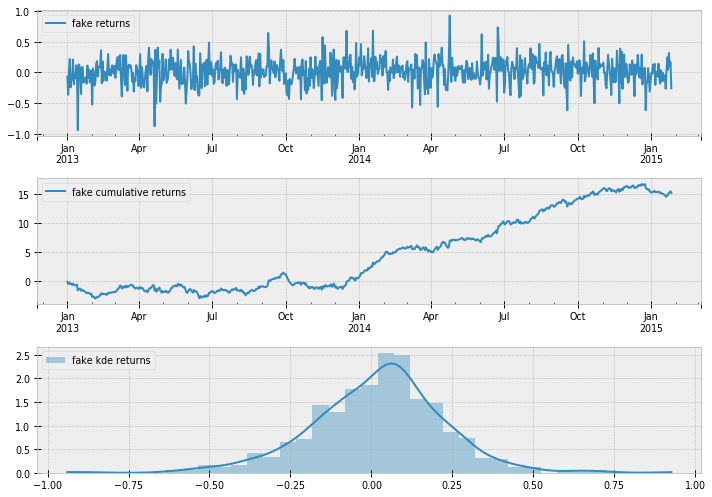

In [3]:
def mix_data(mus, sigmas, probs, n):

    np.random.seed(0)
    # randomly sample from binomial to select distr.
    z = np.random.binomial(1, true_probs[1], n)
    # sample from normal distr. and associated parameters according to z
    X = np.random.normal(true_mus[z], true_sigmas[z])
    
    # fake dates to make it look real
    fake_dates = pd.date_range('2013', periods=n)
    fake_returns = pd.Series(X, index=fake_dates)
    
    return fake_returns

mixed = mix_data(true_mus, true_sigmas, true_probs, n=n)

fig, axs = plt.subplots(nrows=3, figsize=(10,7))#, sharex=True)

mixed.plot(ax=axs[0], label='fake returns')
mixed.cumsum().plot(ax=axs[1], label='fake cumulative returns')
sns.distplot(mixed, ax=axs[2], kde_kws=dict(cut=0), label='fake kde returns')
for ax in axs: 
    ax.legend(loc='upper left') 
    ax.tick_params('both', direction='inout', length=7, width=1, which='major')
plt.tight_layout()

After creating our somewhat realistic looking mixture we need to code our normal distribution class. 

It needs to be able to take mu, sigma parameters and contain methods to compute the log probability density function (logpdf, or log_density) of the data given the parameters. It also needs to be able to estimate the parameters of the normal distribution given the data and weights.

In [27]:
# code adapted from: https://github.com/sseemayer/mixem

class N:
    """Univariate normal distribution with parameters (mu, sigma)."""

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def log_density(self, data):
        """fn: compute log pdf of normal distr. given parameters and data"""
        
        assert(len(data.shape) == 1), "Expect 1D data!"
        
        # uncomment to confirm they produce same values
        #log_pdf = stats.norm.logpdf(data, loc=self.mu, scale=self.sigma)
        log_pdf = - (data - self.mu) ** 2 / (2 * self.sigma ** 2) - np.log(self.sigma) - 0.5 * np.log(2 * np.pi)
        return log_pdf

    def estimate_parameters(self, data, weights):
        """fn: estimate parameters of normal distr. given data and weights"""
        
        assert(len(data.shape) == 1), "Expect 1D data!"

        wsum = np.sum(weights)

        self.mu = np.sum(weights * data) / wsum
        self.sigma = np.sqrt(np.sum(weights * (data - self.mu) ** 2) / wsum)    

Now we can make incorrect guesses about the parameters of the two distributions as initial starting points to the EM algorithm. 

In [15]:
# terrible guesses at the true prior probability
init_stable_prob = 0.5
init_volatile_prob = 0.5

# guesses at starting mean
init_stable_mean = 0.10
init_volatile_mean = -0.025

# guesses at starting std
init_stable_std = 0.10
init_volatile_std = 0.20

init_probs = np.array([init_stable_prob, init_volatile_prob])
init_means = np.array([init_stable_mean, init_volatile_mean])
init_sigmas = np.array([init_stable_std, init_volatile_std])

Now we are ready to code the actual algorithm steps. Code is adapted from [here](https://github.com/sseemayer/mixem/blob/master/mixem/em.py)

In [30]:
# wrap our distributions in a list
distributions = [N(init_means[0], init_sigmas[0]), 
                 N(init_means[1], init_sigmas[1])]
# set data
data = mixed.copy()    

# set algorithm parameters
max_iterations = tol_iters = 550
tol=1e-5

# get key dim info
n_distr = true_mus.shape[0]
n_data = data.shape[0]

weight = np.array(init_probs) # init weight array
last_ll = np.zeros((tol_iters, )) # init log-likelihood array
resp = np.empty((n_data, n_distr)) # init algo weights/resp array
log_density = np.empty((n_data, n_distr)) # init logpdf array

iteration = 0 # init counter

while True:
    # ---------------------------------------------------------
    # E-step 
    # ---------------------------------------------------------
    
    # compute responsibilities aka weights
    for d in range(n_distr):
        log_density[:, d] = distributions[d].log_density(data)
        
    # normalize responsibilities of distributions so they sum up to one for example
    resp = weight[np.newaxis, :] * np.exp(log_density)
    resp /= np.sum(resp, axis=1)[:, np.newaxis]
    
    # compute log-likelihood
    log_likelihood = np.sum(resp @ log_density.T) # matrix multiplication
    
    # ---------------------------------------------------------
    # M-step 
    # ---------------------------------------------------------
    
    for d in range(n_distr):
        distributions[d].estimate_parameters(data, resp[:, d])

    weight = np.mean(resp, axis=0)
    
    # ---------------------------------------------------------
    # check convergence
    # ---------------------------------------------------------
    
    if np.isnan(log_likelihood):
        last_ll[0] = log_likelihood
        break

    if iteration >= tol_iters and (last_ll[-1] - log_likelihood) / last_ll[-1] <= tol:
        last_ll[0] = log_likelihood
        break

    if iteration >= max_iterations:
        last_ll[0] = log_likelihood
        break

    # ---------------------------------------------------------
    # store value of current iteration in last_ll[0]
    #   and shift older values to the right
    # ---------------------------------------------------------    
    last_ll[1:] = last_ll[:-1]
    last_ll[0] = log_likelihood
    
    # ---------------------------------------------------------
    # info display
    # ---------------------------------------------------------    
    mus = np.array([distributions[i].mu for i in range(n_distr)])
    sigs = np.array([distributions[i].sigma for i in range(n_distr)])
    
    regime_map = {0:'stable', 1:'risky'}
    iter_data = (pd.DataFrame(np.vstack([mus, sigs, weight,
                                         true_mus, true_sigmas, true_probs]),
                              columns=[f'{regime_map[i]} regime' for i in range(n_distr)],
                              index=['means', 'sigmas', 'weights',
                                     'true_means', 'true_sigmas', 'true_weights'])
                 .round(3))
    
    if iteration % 50==0:
        print()
        print('-'*77)
        print(f'iteration: {iteration}')
        print(f"ll new: {last_ll[0].round(3)}")
        display(iter_data.T)
    iteration += 1        


-----------------------------------------------------------------------------
iteration: 0
ll new: -228381.861


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.094,0.110,0.44,0.050,0.15,0.65
risky regime,-0.037,0.244,0.56,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 50
ll new: -19134.81


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.046,0.131,0.525,0.050,0.15,0.65
risky regime,-0.009,0.264,0.475,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 100
ll new: -3782.573


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.043,0.139,0.596,0.050,0.15,0.65
risky regime,-0.013,0.275,0.404,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 150
ll new: 3901.633


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.041,0.143,0.634,0.050,0.15,0.65
risky regime,-0.016,0.282,0.366,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 200
ll new: 7825.76


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.040,0.145,0.654,0.050,0.15,0.65
risky regime,-0.017,0.286,0.346,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 250
ll new: 9836.579


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.146,0.664,0.050,0.15,0.65
risky regime,-0.018,0.288,0.336,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 300
ll new: 10867.023


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.147,0.67,0.050,0.15,0.65
risky regime,-0.019,0.289,0.33,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 350
ll new: 11394.855


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.147,0.672,0.050,0.15,0.65
risky regime,-0.019,0.290,0.328,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 400
ll new: 11665.142


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.148,0.674,0.050,0.15,0.65
risky regime,-0.019,0.290,0.326,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 450
ll new: 11803.52


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.148,0.674,0.050,0.15,0.65
risky regime,-0.019,0.290,0.326,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 500
ll new: 11874.358


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.148,0.675,0.050,0.15,0.65
risky regime,-0.019,0.290,0.325,-0.025,0.30,0.35


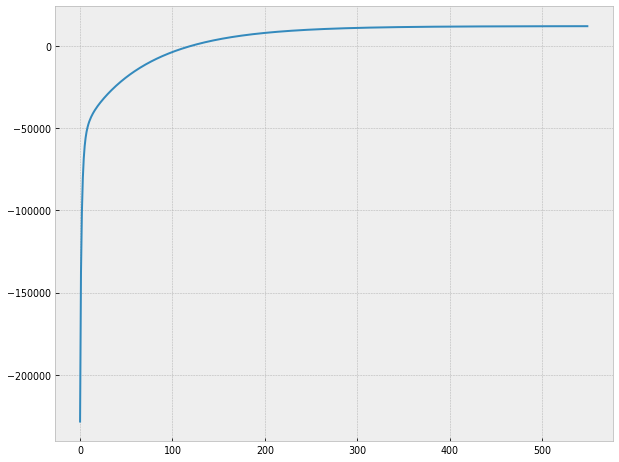

In [33]:
pd.Series(last_ll[::-1]).plot()

Not bad right? This algorithm is pretty flexible although you can adjust the true parameters and/or the guesses and you will find some of the limitations. However how those are addressed are beyond the scope of this chapter.

My goal was to provide a simple working example of the algorithm, in order for us to gain a deeper understanding of what is happening inside the black box of the algorithm. 

Now we can move forward.

In [7]:
load_parquet = lambda fp: (pq.read_table(fp).to_pandas().assign(year=lambda df: df.index.year))

load_fp = PurePath(pdir, 'data/etf_returns_2004-11-19-2017-09-29.parquet').as_posix()
rdf = load_parquet(load_fp)
cprint(rdf)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                 EEM       EFA       GLD       QQQ       SPY       TLT  year
Date                                                                        
2017-09-25 -0.017113 -0.005719  0.010413 -0.010588 -0.002047  0.006240  2017
2017-09-26 -0.002694 -0.002208 -0.011225  0.002588  0.000602 -0.001813  2017
2017-09-27 -0.003603  0.000737 -0.009465  0.008970  0.003887 -0.015183  2017
2017-09-28 -0.000677  0.002647  0.001884 -0.000346  0.001199 -0.002968  2017
2017-09-29  0.011447  0.005858 -0.005168  0.007176  0.003509  0.002247  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3238 entries, 2004-11-19 to 2017-09-29
Data columns (total 7 columns):
EEM     3238 non-null float64
EFA     3238 non-null float64
GLD     3238 non-null float64
QQQ     3238 n

In [8]:
sym = 'SPY' # example symbol
df = rdf.loc['2005':].copy() # use 2005 cutoff b/c it's first full year of data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3209 entries, 2005-01-03 to 2017-09-29
Data columns (total 7 columns):
EEM     3209 non-null float64
EFA     3209 non-null float64
GLD     3209 non-null float64
QQQ     3209 non-null float64
SPY     3209 non-null float64
TLT     3209 non-null float64
year    3209 non-null int64
dtypes: float64(6), int64(1)
memory usage: 200.6 KB


In [9]:
# conv fn to add mean std text to plot
def add_mean_std_text(x, **kwargs):
    """fn: add mean, std text to seaborn plot
    
    # Args
        x : pd.Series()
    """
    mean, std = x.mean(), x.std()
    mean_tx = f"mean: {mean:.4%}\nstd: {std:.4%}"
    
    txkw = dict(size=14, fontweight='medium', color='k', rotation=0)
    ymin, ymax = plt.gca().get_ylim()
    plt.text(mean+0.025, 0.8*ymax, mean_tx, **txkw)
    return

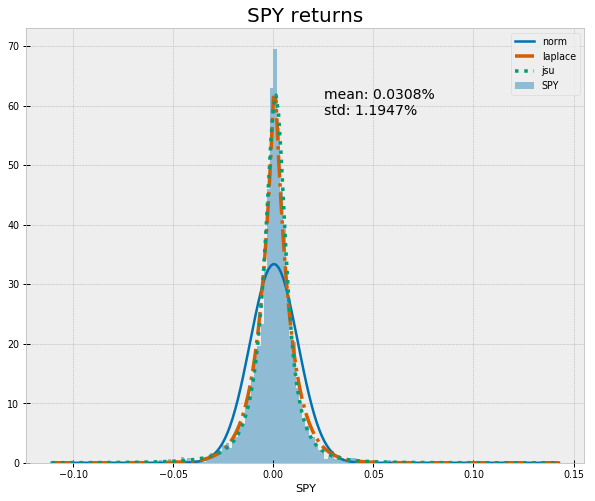

In [10]:
fig, ax = plt.subplots()

s = df[sym]

ax.hist(s, alpha=0.5, bins=150, normed=True);

sns.distplot(s, ax=ax, hist=False, kde=False, fit=stats.norm,
             fit_kws={'linestyle':'-', 'color':blue, 'lw':2.5, 'label':'norm'})
sns.distplot(s, ax=ax, hist=False, kde=False, fit=stats.laplace, 
             fit_kws={'linestyle':'-.', 'color':red, 'lw':3.5, 'label':'laplace'})
sns.distplot(s, ax=ax, hist=False, kde=False, fit=stats.johnsonsu,
             fit_kws={'linestyle':':', 'color':green, 'lw':3.5, 'label':'jsu'})
ax.set_title(f'{sym} returns', fontsize=20, fontweight='medium')
ax.tick_params('both', direction='inout', length=7, width=1, which='major')
ax.legend()

add_mean_std_text(s)

Continuing with our example, using SPY returns, let's use sklearn to fit a GMM model. First we will fit one using a single component. This is equivalent to fitting a single normal distribution to the set of returns.

In [11]:
def make_gmm(n_components, max_iter=150, random_state=RANDOM_STATE):
    """fn: create gmm object"""
    model_kwds = dict(n_components=n_components, 
                      max_iter=max_iter,
                      n_init=100,
                      random_state=RANDOM_STATE)

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm

#######
max_iter = 150 
_X = s.reshape(-1, 1)

gmm1 = make_gmm(1, max_iter)
gmm1.fit(_X)

preds = gmm1.predict(_X)
gmm1.means_, gmm1.covariances_, np.sqrt(gmm1.covariances_), gmm1.aic(_X), gmm1.bic(_X)

(array([[ 0.00030842]]),
 array([[[ 0.00014369]]]),
 array([[[ 0.01198698]]]),
 -19304.393816085139,
 -19292.246386802919)

Note that the mean and standard deviation is the same as computed in the previous plot. Also note the `aic` and `bic` metrics. These reference the [`Akaike Information Criterion`](https://en.wikipedia.org/wiki/Akaike_information_criterion) and the [`Bayesian Information Criterion`](https://en.wikipedia.org/wiki/Bayesian_information_criterion). Without delving too heavily into the theoretical pros and cons of each, we can just say they are both methods which allow us to compare the relative suitability of different models. Generally speaking, when choosing among a set of models we want to choose the `aic` or `bic` with the smallest information criterion value.

> AIC rewards goodness of fit (as assessed by the likelihood function), but it also includes a penalty that is an increasing function of the number of estimated parameters. The penalty discourages overfitting, because increasing the number of parameters in the model almost always improves the goodness of the fit. - [wikipedia](https://en.wikipedia.org/wiki/Akaike_information_criterion)

The importance of the penalty component in each of the ICs cannot be overstated. As always, in the limit, you could technically fit a distribution, or add a parameter for _every_ datapoint, thereby grossly overfitting the model. 

Both metrics implement a penalty, however the `bic` penalizes additional parameters more heavily than the `aic` and will always result in a selecting fewer parameters than the `aic` would. Let's walkthrough a quick demo of this.

In [12]:
gmm2 = make_gmm(2, max_iter)
gmm2.fit(_X)

gmm2.means_, gmm2.covariances_, gmm2.aic(_X), gmm2.bic(_X)

(array([[-0.00263246],
        [ 0.00089767]]), array([[[  6.14422437e-04]],
 
        [[  4.72895216e-05]]]), -20469.340677899287, -20438.972104693737)

Above we fit a GMM model with `2` components. Notice that both the `aic` and `bic` are smaller than their single component counterparts. This implies that the model with `2` components is "better" than the one with a single component. What about more components? Let's try `10`. 

In [13]:
gmm10 = make_gmm(10, max_iter)
gmm10.fit(_X)

gmm10.means_, gmm10.covariances_, gmm10.aic(_X), gmm10.bic(_X)

(array([[ 0.00174487],
        [-0.02127485],
        [ 0.03218533],
        [-0.07698017],
        [-0.00239338],
        [ 0.01576889],
        [ 0.12303798],
        [-0.04190984],
        [ 0.00767909],
        [-0.01028666]]), array([[[  8.60805439e-06]],
 
        [[  3.37830536e-05]],
 
        [[  1.60395923e-04]],
 
        [[  2.36984238e-04]],
 
        [[  1.01469164e-05]],
 
        [[  2.24100205e-05]],
 
        [[  1.58469532e-04]],
 
        [[  6.75960043e-05]],
 
        [[  1.22318000e-05]],
 
        [[  1.49550740e-05]]]), -20586.979865048561, -20410.842140456374)

Now we see an example where the `aic` has improved by getting smaller but the `bic` is actually larger than the `2` component model. Here we see the result of the `bic` penalizing additional parameters more heavily. 

Below we can see a comparison between the two metrics as we increase the number of components. We can also see that they choose different numbers of optimal components.

In [14]:
def make_ic_series(list_of_tups, name=None):
    """fn: convert list of tuples for 
            information criterion (aic, bic) into series
    # args
        list_of_tups : list() of tuples()
            tuple[0] is n_component, tuple[1] is IC
        name : str(), name of IC
    
    # returns
        s : pd.Series()
            index is n_components, values are IC's
    """
    s = (pd.DataFrame(list_of_tups)
          .rename(columns={0:'n_components', 1:name})
          .set_index('n_components')
          .squeeze())
    return s

CPU times: user 2.47 s, sys: 5.71 s, total: 8.18 s
Wall time: 1.06 s


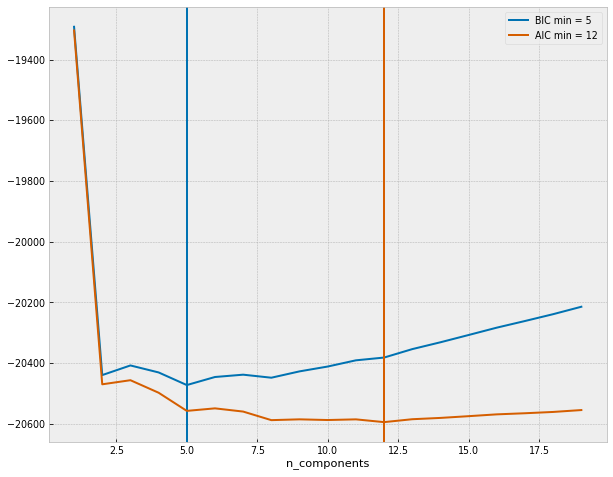

In [15]:
%%time 

n_components = np.arange(1,20)
aics = []
bics = []

for n in n_components:
    tmp_gmm = make_gmm(n, max_iter).fit(_X)
    aics.append((n, tmp_gmm.aic(_X)))
    bics.append((n, tmp_gmm.bic(_X)))

bics = make_ic_series(bics, 'bic')
aics = make_ic_series(aics, 'aic')
    
plt.plot(n_components, bics.values, color=blue, label=f'BIC min = {np.argmin(bics)}')
plt.axvline(np.argmin(bics), color=blue)

plt.plot(n_components, aics.values, color=red, label=f'AIC min = {np.argmin(aics)}')
plt.axvline(np.argmin(aics), color=red)

plt.legend(loc='best')
plt.xlabel('n_components');

As shown above the `aic` selects `12` components as being the best model whereas the `bic` selects only `5`. For convenience we will use the `bic` recommendation for the remainder of the this notebook. One exercise I leave for the reader is to run the `aic`, `bic`, component analysis using different asset returns, and using different lookback periods. 

Below is a demonstration of the how varied the components are across multiple lookback periods. 

CPU times: user 36.7 s, sys: 26.3 s, total: 1min 2s
Wall time: 28.6 s


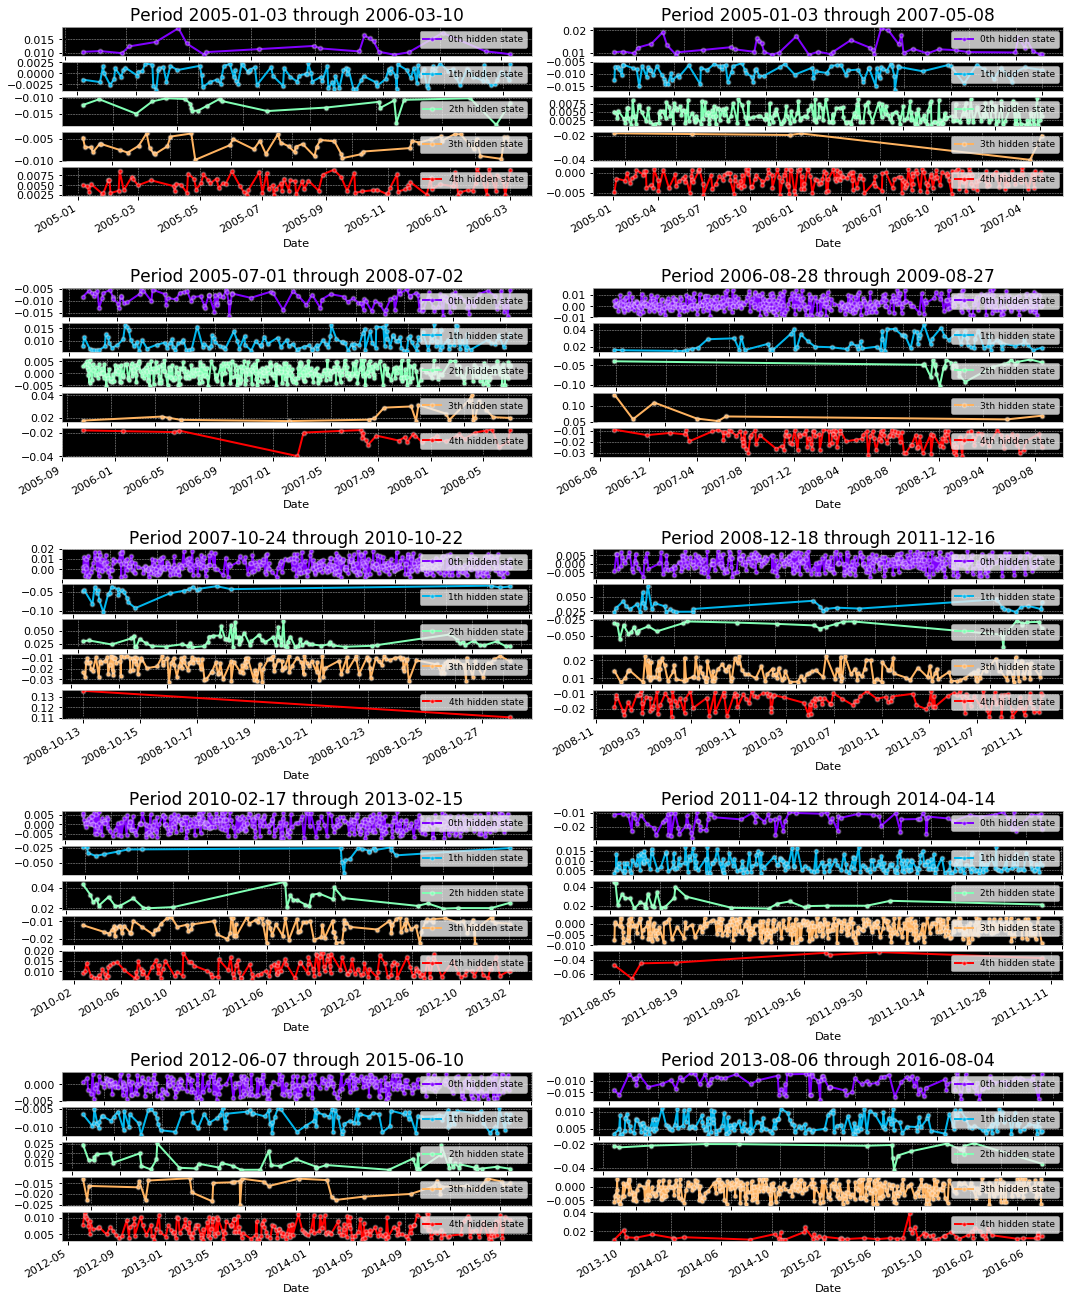

In [16]:
%%time
np.random.seed(0)

lookback = 252 * 3 # 3 trading years
n_components = 5
max_iter = 1000
n_split = n_components * 2
grid_rows = math.ceil(n_split/2)

# stash data in lists
preds = []
pred_means = []
pred_covs = []

### begin plot code ###
fig = plt.figure(figsize=(15,20))
outer_grid = gridspec.GridSpec(grid_rows, 2)
colors = plt.cm.rainbow(np.linspace(0, 1, n_components))

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)

for i, (train, test) in enumerate(tscv.split(s)):
    tmp_train = s.iloc[train] # temporary train data
    tmp_test = s.iloc[test] # temporary test data
    
    _X = tmp_train.reshape(-1,1) # format pd.Series for sklearn
    gmm = make_gmm(n_components, max_iter) # make model
    gmm.fit(_X) # fit model
    
    # predict hidden states
    hidden_states = gmm.predict(_X)
    
    # store output in lists
    preds.append(hidden_states)
    pred_means.append(gmm.means_)
    pred_covs.append(gmm.covariances_)
    
    # make inner grid for subplots
    inner_grid = gridspec.GridSpecFromSubplotSpec(n_components, 1,
                                                  subplot_spec=outer_grid[i],
                                                  wspace=0.0, hspace=0.2)
    title_text = f"Period {tmp_train.index.min().strftime('%Y-%m-%d')} through {tmp_train.index.max().strftime('%Y-%m-%d')}"
    for j, (_, color) in enumerate(zip(range(grid_rows), colors)):
       
        hs = pd.Series(hidden_states.copy())
        mask = hs[hs==j] # index locs of each hidden state
        
        tmp_ax = plt.Subplot(fig, inner_grid[j,:]) # make inner grid ax
        marker_edge_color = mpl.colors.colorConverter.to_rgba('white', alpha=.3)
        tmp_train[mask.index].plot(ax=tmp_ax, c=color,
                                   marker='o', markersize=4,
                                   markeredgecolor=marker_edge_color,
                                   markeredgewidth=1.75, label=f"{j}th hidden state")
        tmp_ax.set_facecolor('k')#sns.xkcd_rgb['slate'])
        tmp_ax.legend(loc='upper right', fontsize=9)

        tmp_ax.tick_params(axis='x', which='both', labelsize=11, rotation=30)
        tmp_ax.tick_params(axis='y', which='both', labelsize=11)
        tmp_ax.tick_params(axis='both', direction='inout', length=7, width=1, which='major')
        
        if j==0: tmp_ax.set_title(title_text, fontsize=17, fontweight='medium')
        if j < (grid_rows-1): 
            tmp_ax.set_xticklabels([])
            tmp_ax.set_xlabel('')          
        fig.add_subplot(tmp_ax) # add inner grid ax to figure
        plt.tight_layout()
    
plt.savefig((pdir / 'visuals/02_Gaussian_Mixtures/grid-test.png').as_posix(),
            dpi=300, bbox_inches='tight') 

We can see how varied the components are across different time periods. Some components are more active while others are rarely active. Additionally notice how some components are clustered over shorter sub periods while others are more evenly distributed.

Next we visualize these relationships further. For each time period, we plot the cumulative returns, color and shape coded to represent the different components. Then we show a boxplot of the aggregate returns over the period. Finally we print out the statistical description of the dataframe using `pandas.describe()`.  

In [51]:
def plot_cuml_state(states, state_col=None):
    g = (pn.ggplot(states, pn.aes(x='Date',y='mkt_cret', color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'))
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['mkt_cret'].min(), states['mkt_cret'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g

def plot_facet_cuml_states(states, state_col=None):
    g = (pn.ggplot(states, pn.aes(x='Date',y='mkt_cret', color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'))
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')         
         + pn.facet_wrap(f'~{state_col}')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['mkt_cret'].min(), states['mkt_cret'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g

def plot_states_boxplot(states, state_col, y_col):
    g = (pn.ggplot(states, pn.aes(x=state_col, y=y_col, color=f'factor({state_col})')) 
         + pn.geom_boxplot()
         + pn.geom_jitter(alpha=0.5)
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')         
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states[y_col].min(), states[y_col].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=30),) 
         + pn.ylab('log returns')
         + pn.ggtitle('Log Returns by Hidden State'))
    return g

With the plotting functions defined we can loop through the `TimeseriesSplit` object to generate the plots and descriptive tables for each lookback/training period. 


*****************************************************************************


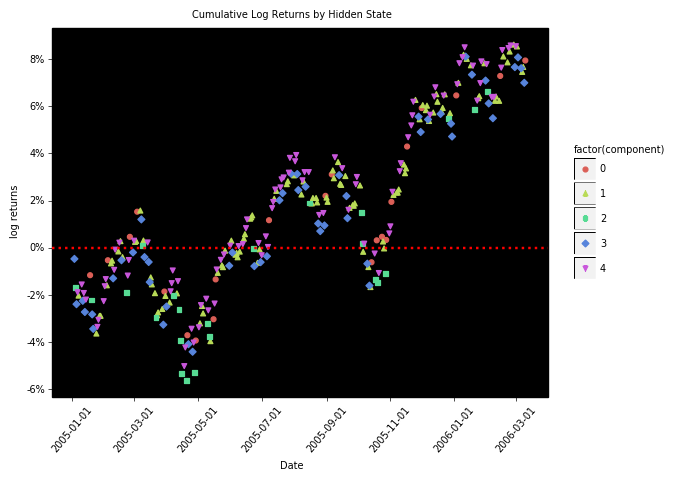

<ggplot: (8742665347525)>


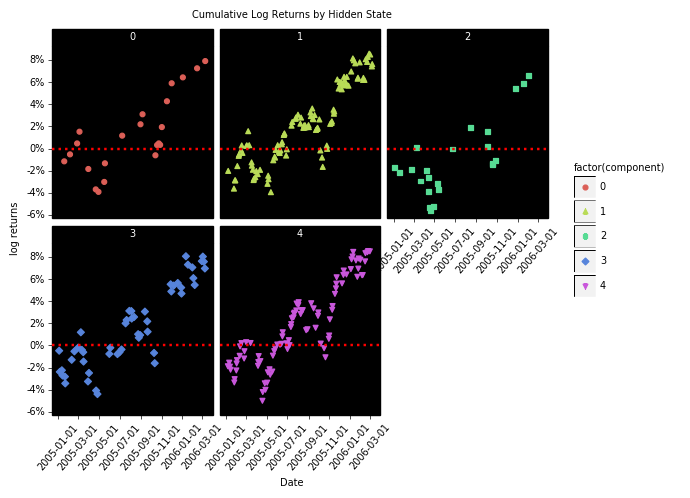

<ggplot: (-9223363294190000794)>


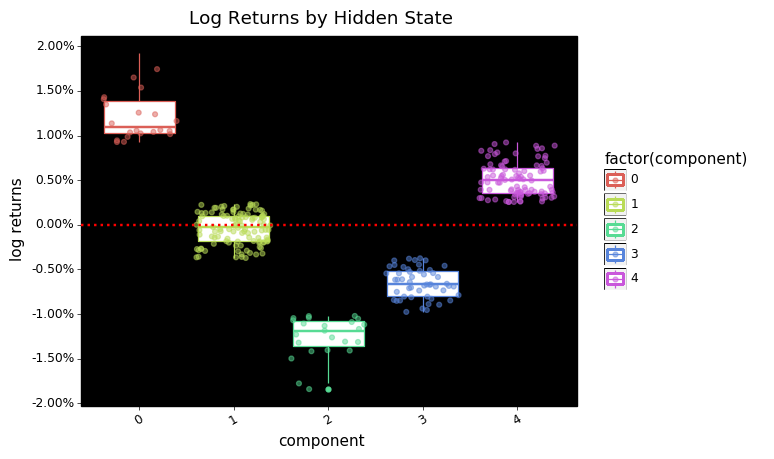

<ggplot: (-9223363294189961861)>


component,0,1,2,3,4
count,22.000000,110.000000,23.000000,51.000000,93.000000
mean,0.012226,-0.000394,-0.012535,-0.006523,0.005104
std,0.002837,0.001744,0.002264,0.001658,0.001888
min,0.009269,-0.003719,-0.018406,-0.009761,0.002553
25%,0.010266,-0.001856,-0.013626,-0.007964,0.003550
50%,0.010988,-0.000294,-0.011865,-0.006671,0.004962
75%,0.013916,0.001023,-0.010793,-0.005215,0.006327
max,0.019234,0.002320,-0.010213,-0.003753,0.009222



*****************************************************************************


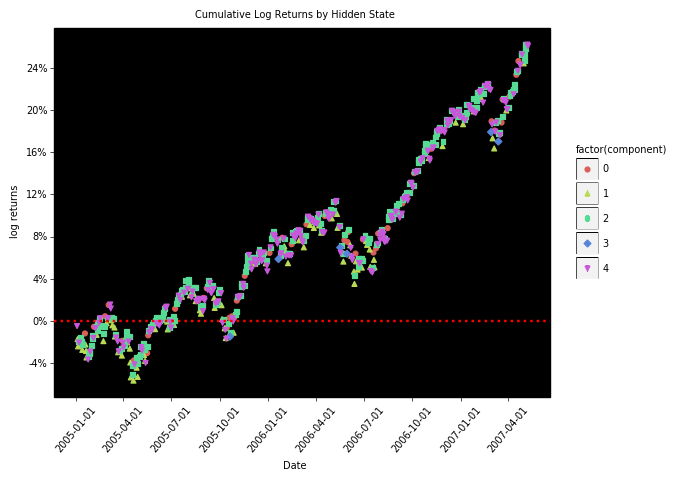

<ggplot: (-9223363294183370706)>


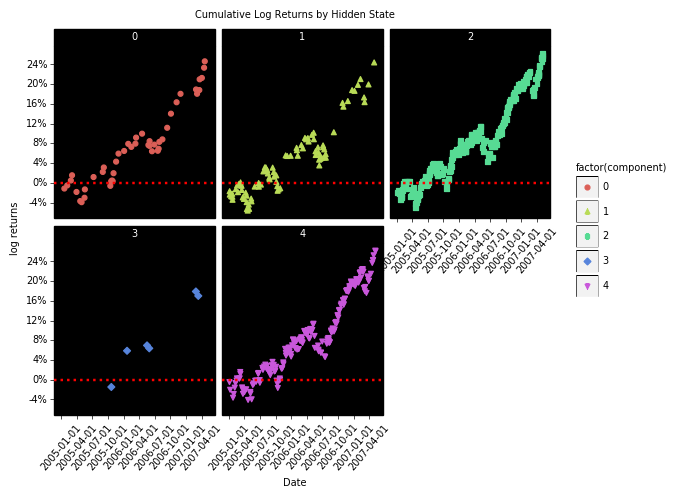

<ggplot: (8742678834580)>


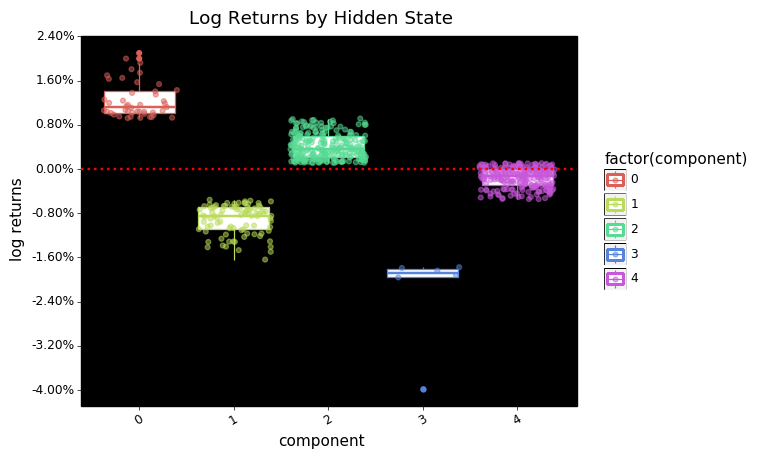

<ggplot: (8742670663060)>


component,0,1,2,3,4
count,45.000000,89.000000,238.000000,6.000000,212.000000
mean,0.012444,-0.009159,0.004131,-0.022128,-0.001578
std,0.003203,0.002640,0.002260,0.008707,0.001788
min,0.009222,-0.016397,0.001113,-0.039841,-0.005447
25%,0.010199,-0.010909,0.002121,-0.019521,-0.002976
50%,0.011216,-0.008417,0.003633,-0.018806,-0.001315
75%,0.014061,-0.006924,0.005935,-0.018041,-0.000080
max,0.020992,-0.005564,0.009140,-0.017773,0.001058



*****************************************************************************


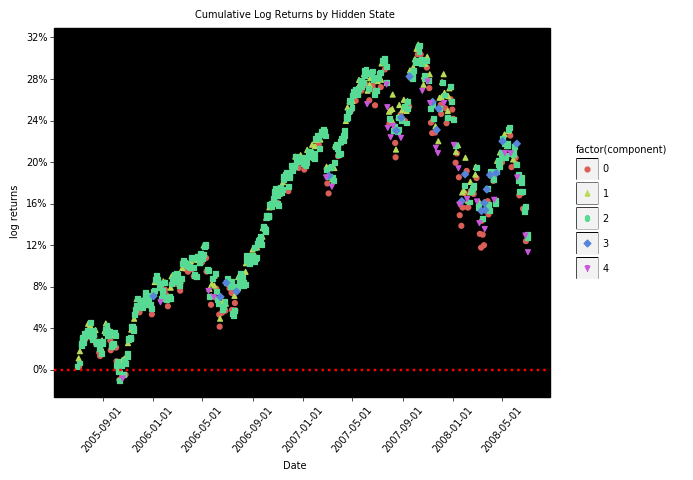

<ggplot: (-9223363294189498729)>


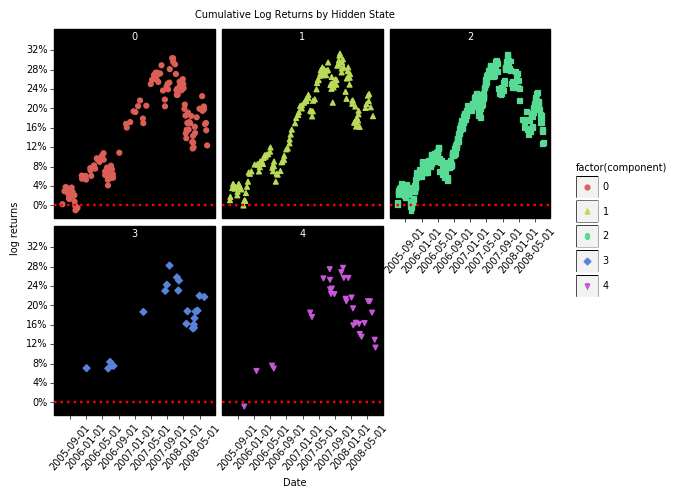

<ggplot: (8742665647059)>


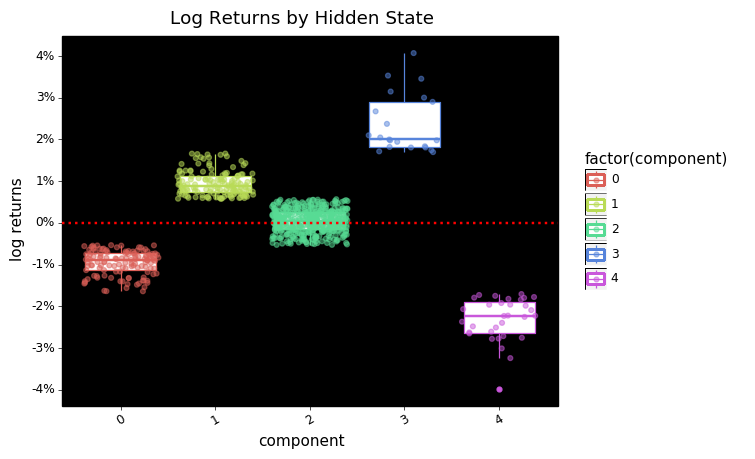

<ggplot: (-9223363294189032199)>


component,0,1,2,3,4
count,125.000000,144.000000,434.000000,21.000000,32.000000
mean,-0.009581,0.009461,0.000443,0.023633,-0.023133
std,0.002902,0.002886,0.002737,0.007105,0.005162
min,-0.016397,0.005763,-0.005273,0.016965,-0.039841
25%,-0.011327,0.007309,-0.001539,0.018201,-0.026319
50%,-0.008886,0.008821,0.000470,0.019999,-0.022285
75%,-0.007314,0.011211,0.002567,0.029014,-0.019007
max,-0.005340,0.016621,0.005674,0.040703,-0.017059



*****************************************************************************


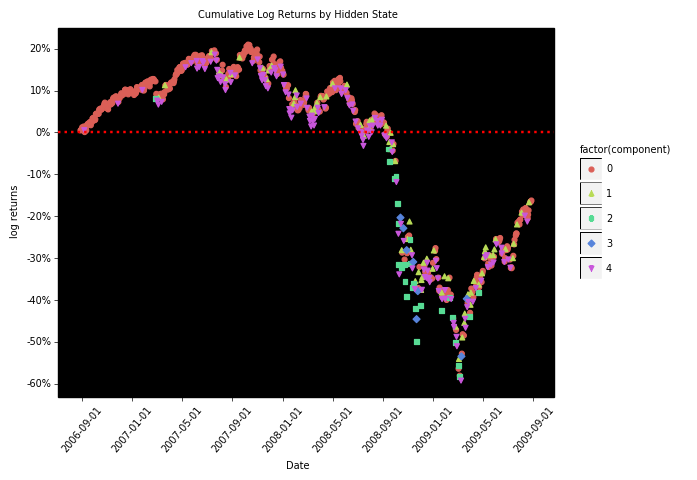

<ggplot: (-9223363294184501276)>


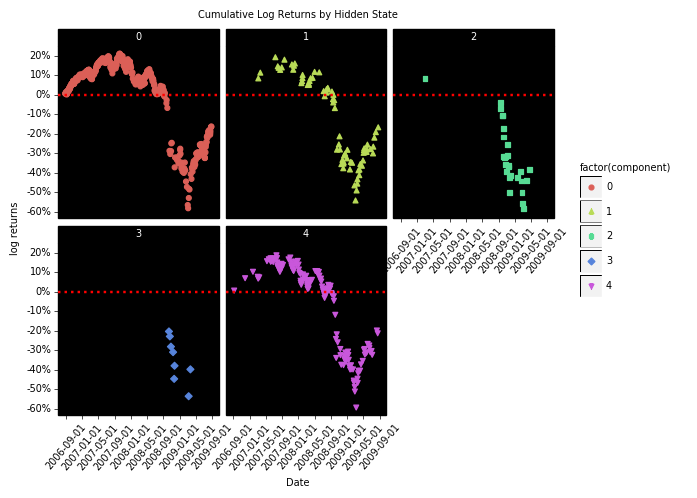

<ggplot: (8742670644407)>


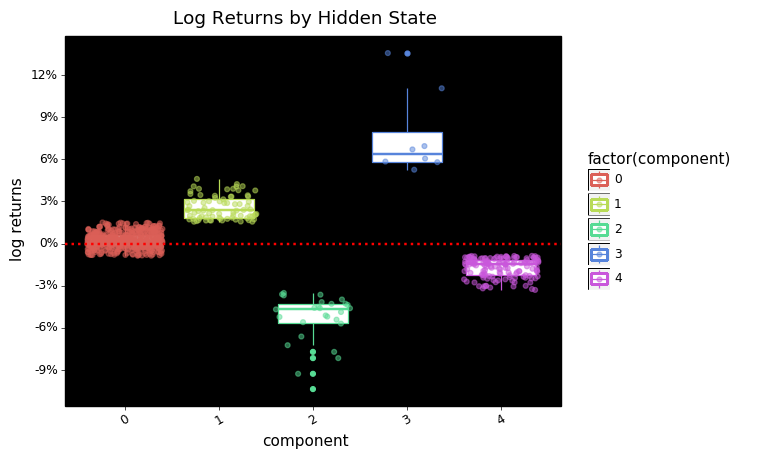

<ggplot: (8742664796943)>


component,0,1,2,3,4
count,503.000000,76.000000,27.000000,8.000000,142.000000
mean,0.002312,0.025601,-0.053732,0.076464,-0.017130
std,0.005448,0.008204,0.017657,0.029988,0.006626
min,-0.008691,0.015518,-0.103637,0.052538,-0.033038
25%,-0.001195,0.018396,-0.056499,0.058233,-0.022298
50%,0.001743,0.023581,-0.046892,0.063735,-0.014797
75%,0.005959,0.031733,-0.042878,0.079654,-0.011426
max,0.014998,0.045991,-0.035166,0.135577,-0.008793



*****************************************************************************


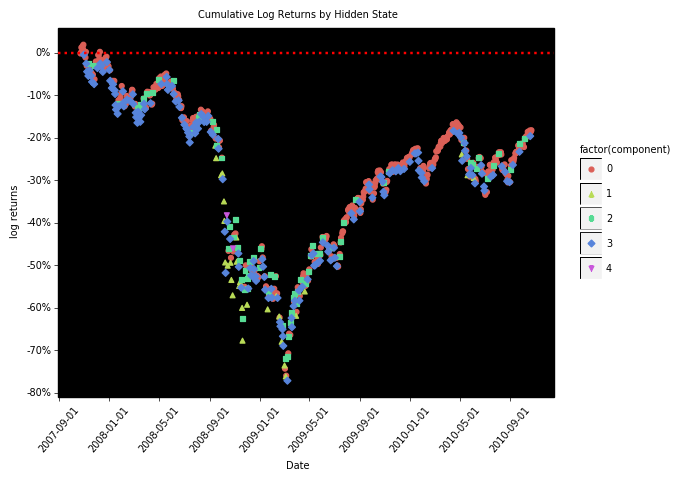

<ggplot: (8742664854329)>


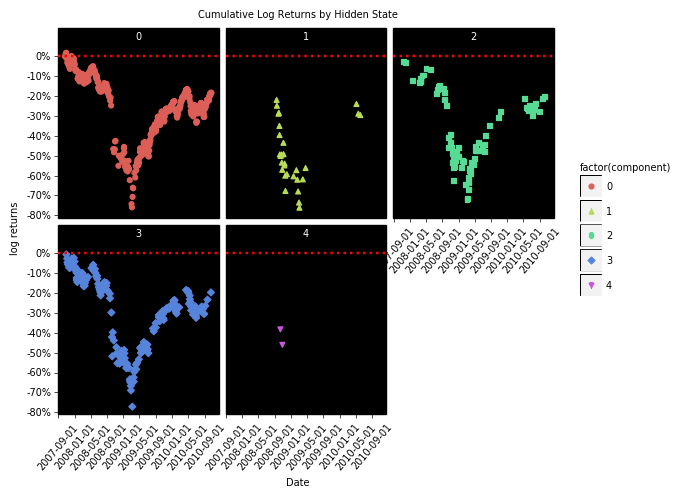

<ggplot: (-9223363294184418830)>


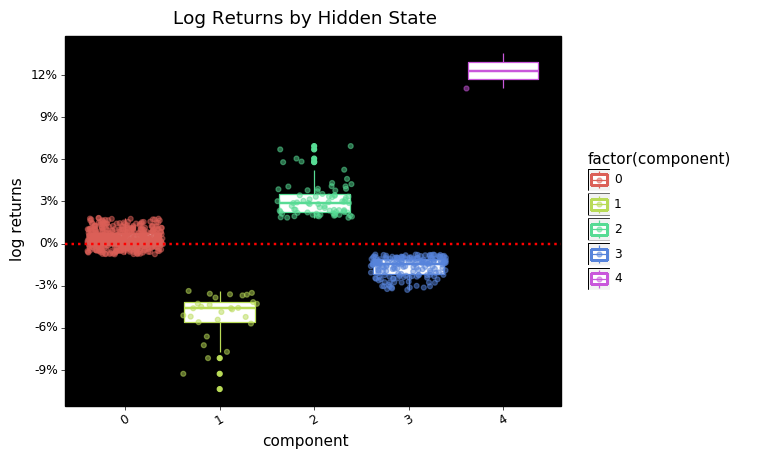

<ggplot: (8742671379148)>


component,0,1,2,3,4
count,476.000000,29.000000,75.000000,174.000000,2.000000
mean,0.003491,-0.052378,0.030705,-0.016518,0.123047
std,0.006200,0.017741,0.011538,0.006763,0.017720
min,-0.007709,-0.103637,0.018353,-0.033038,0.110517
25%,-0.000995,-0.055993,0.022107,-0.021620,0.116782
50%,0.002787,-0.046089,0.028812,-0.014498,0.123047
75%,0.007665,-0.041705,0.034931,-0.010895,0.129312
max,0.018228,-0.033777,0.069366,-0.007851,0.135577



*****************************************************************************


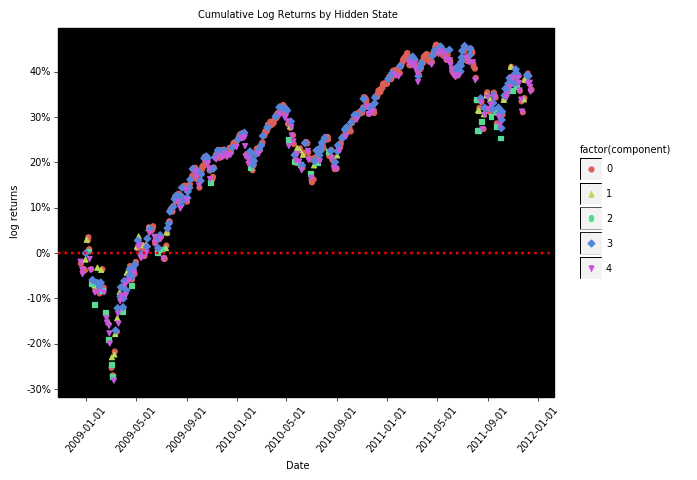

<ggplot: (-9223363294189627567)>


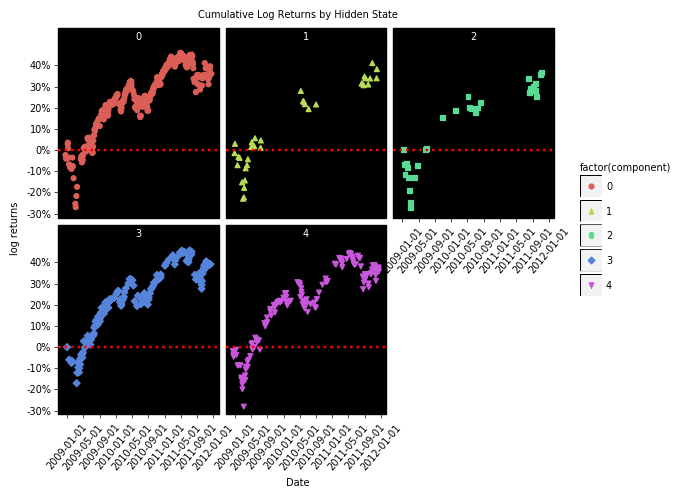

<ggplot: (-9223363294183312752)>


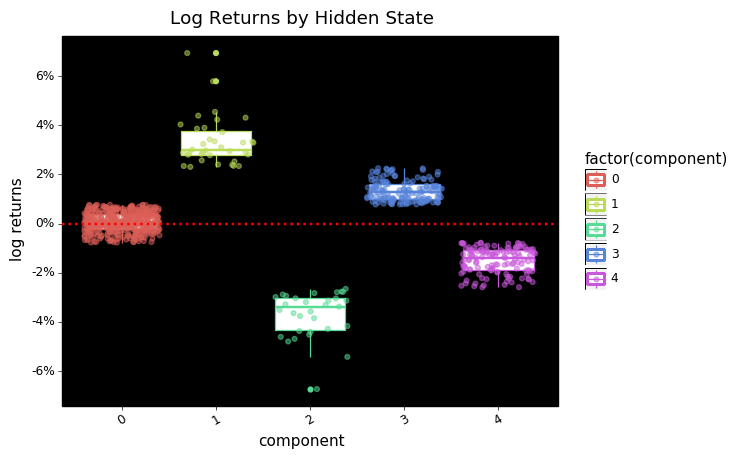

<ggplot: (-9223363294169465442)>


component,0,1,2,3,4
count,411.000000,36.000000,31.000000,148.000000,130.000000
mean,0.000689,0.033230,-0.036939,0.013345,-0.014987
std,0.003922,0.009852,0.009267,0.004171,0.005102
min,-0.007729,0.023065,-0.067341,0.007747,-0.025882
25%,-0.002030,0.027963,-0.043268,0.009886,-0.018816
50%,0.000715,0.029910,-0.033777,0.012738,-0.013843
75%,0.003819,0.037561,-0.030158,0.016121,-0.010815
max,0.007645,0.069366,-0.026559,0.022521,-0.007851



*****************************************************************************


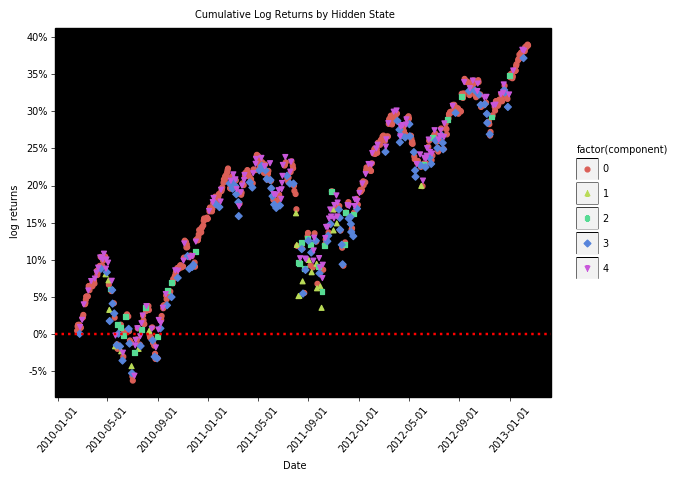

<ggplot: (8742670808654)>


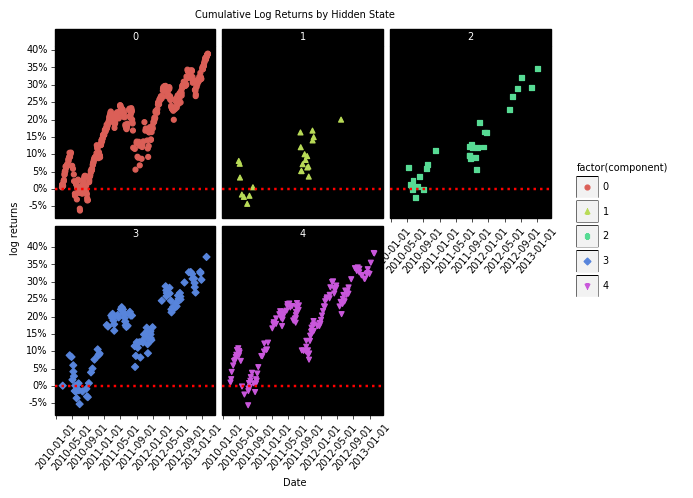

<ggplot: (-9223363294189927792)>


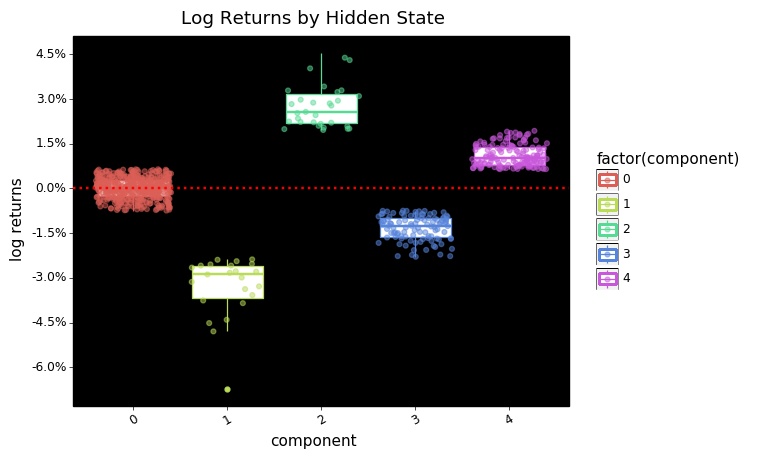

<ggplot: (-9223363294183435355)>


component,0,1,2,3,4
count,450.000000,23.000000,31.000000,105.000000,147.000000
mean,0.000100,-0.032977,0.027777,-0.013267,0.011117
std,0.003458,0.010309,0.007505,0.004121,0.003554
min,-0.007415,-0.067341,0.019639,-0.022924,0.006507
25%,-0.002527,-0.036688,0.021881,-0.016290,0.008041
50%,0.000271,-0.028871,0.025706,-0.012509,0.010285
75%,0.002815,-0.025881,0.031696,-0.009960,0.013833
max,0.006449,-0.023796,0.045450,-0.007457,0.019357



*****************************************************************************


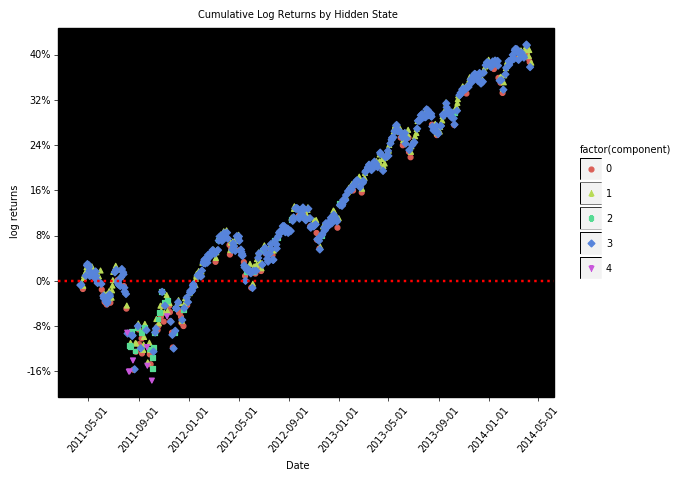

<ggplot: (-9223363294189047401)>


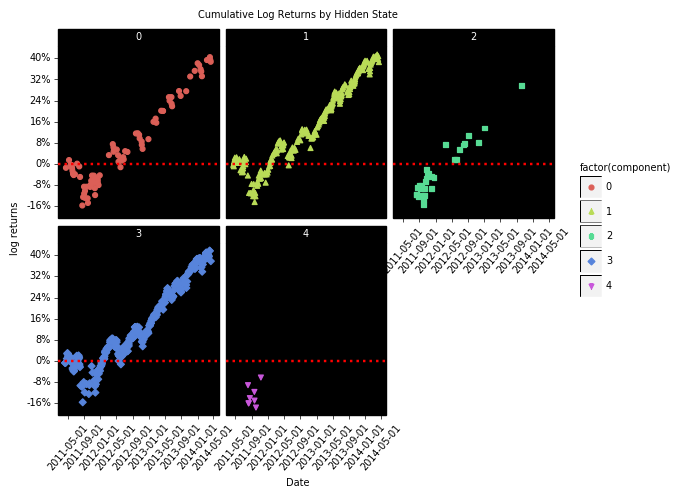

<ggplot: (-9223363294189345974)>


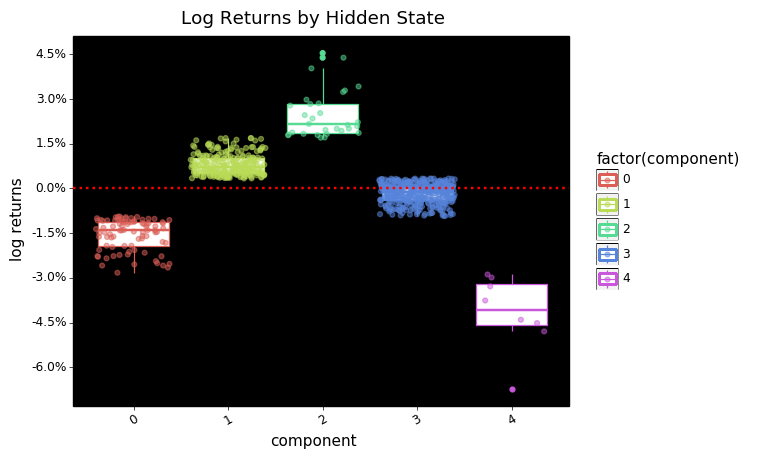

<ggplot: (-9223363294183902471)>


component,0,1,2,3,4
count,86.000000,245.000000,30.000000,387.000000,8.000000
mean,-0.015397,0.007985,0.024818,-0.001698,-0.041726
std,0.005187,0.003481,0.008030,0.003284,0.012611
min,-0.028285,0.003366,0.017042,-0.009264,-0.067341
25%,-0.019208,0.005103,0.018688,-0.003950,-0.045881
50%,-0.013991,0.007288,0.021508,-0.001140,-0.040842
75%,-0.011160,0.010235,0.028499,0.000787,-0.032119
max,-0.009383,0.016949,0.045450,0.003343,-0.028871



*****************************************************************************


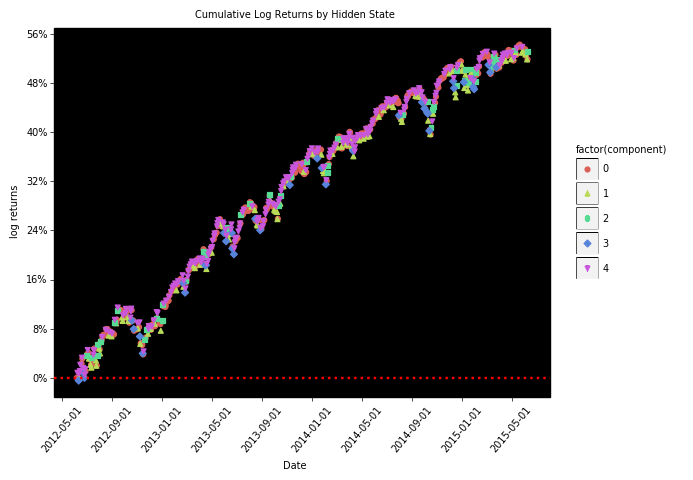

<ggplot: (-9223363294189230143)>


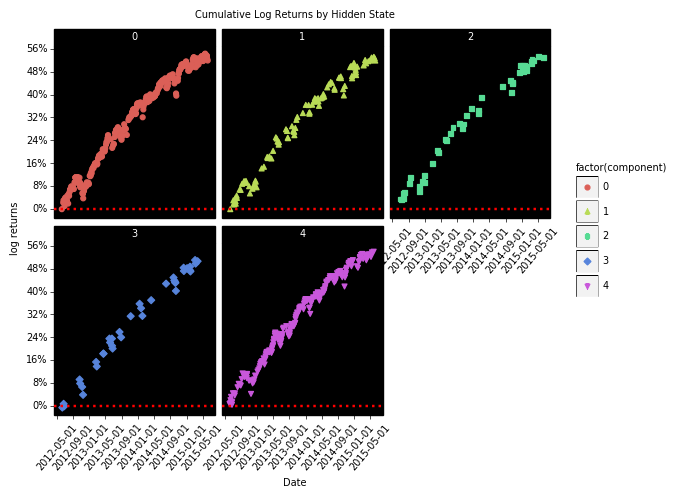

<ggplot: (-9223363294184430476)>


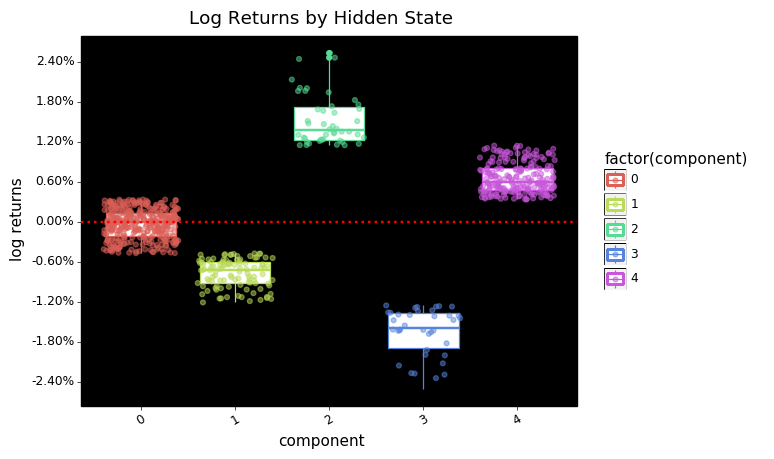

<ggplot: (-9223363294169366661)>


component,0,1,2,3,4
count,355.000000,105.000000,46.000000,38.000000,212.000000
mean,-0.000355,-0.007733,0.015255,-0.016524,0.006578
std,0.002192,0.002084,0.003773,0.003631,0.002245
min,-0.004706,-0.012097,0.011492,-0.025090,0.003366
25%,-0.002123,-0.009203,0.012336,-0.018964,0.004731
50%,-0.000060,-0.007218,0.013701,-0.015859,0.005977
75%,0.001355,-0.006098,0.017236,-0.013712,0.008024
max,0.003341,-0.004749,0.025307,-0.012542,0.011425



*****************************************************************************


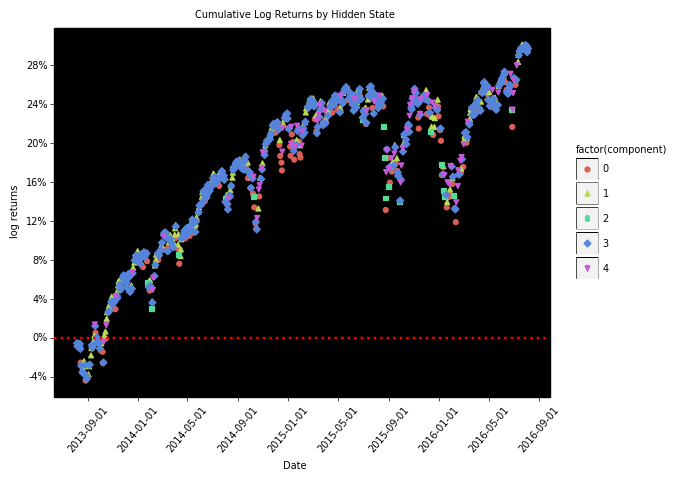

<ggplot: (8742665401131)>


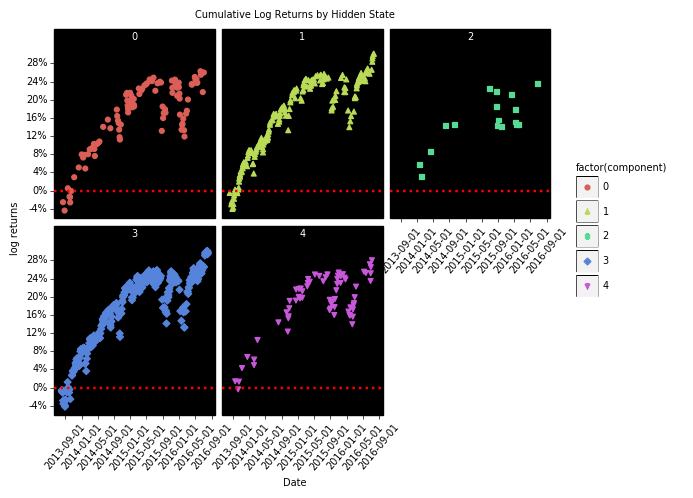

<ggplot: (8742665401955)>


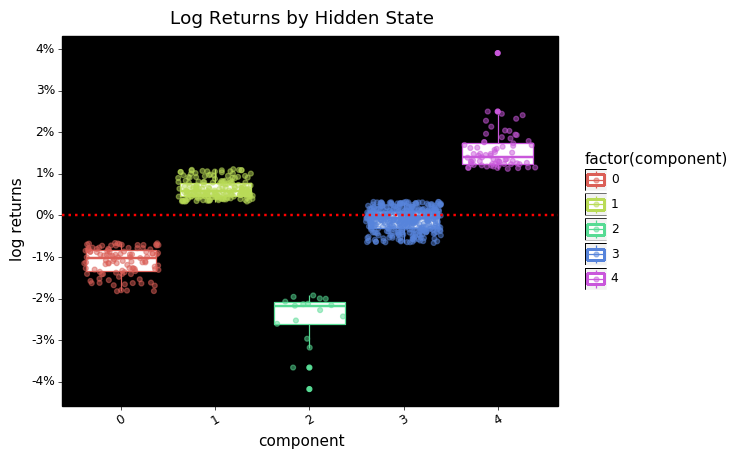

<ggplot: (8742671663736)>


component,0,1,2,3,4
count,105.000000,186.000000,17.000000,380.000000,68.000000
mean,-0.011029,0.006332,-0.024907,-0.000942,0.015576
std,0.003215,0.002162,0.006470,0.002604,0.004609
min,-0.018225,0.003317,-0.041744,-0.006622,0.011194
25%,-0.013278,0.004559,-0.026053,-0.002912,0.012356
50%,-0.010258,0.005773,-0.021700,-0.000691,0.014158
75%,-0.008364,0.007907,-0.020714,0.001122,0.017401
max,-0.006644,0.011115,-0.019234,0.003265,0.039019


In [52]:
### RUN ###
for i, (train, test) in enumerate(tscv.split(s)):
    tmp_train = s.iloc[train].reshape(-1,1) # temporary train data
    tmp_test = s.iloc[test].reshape(-1,1) # temporary test data

    gmm = make_gmm(n_components, max_iter)
    gmm.fit(tmp_train)
    
    hidden_states = gmm.predict(tmp_train)
    
    state_df = (s.iloc[train].to_frame()
                .assign(component=hidden_states)
                .assign(mkt_cret=lambda df: df[sym].cumsum())
                .reset_index())
    
    scol = 'component'
    g = plot_cuml_state(state_df, state_col=scol)
    g1 = plot_facet_cuml_states(state_df, state_col=scol)
    g2 = plot_states_boxplot(state_df, scol, sym)
    print()
    print('*'*77)
    print(g)
    print(g1)
    print(g2)
    display(state_df.groupby(scol)[sym].describe().T)

Finally we wrap up this concept by plotting the `kde` of the returns with the component probability densities plotted inside as well. 

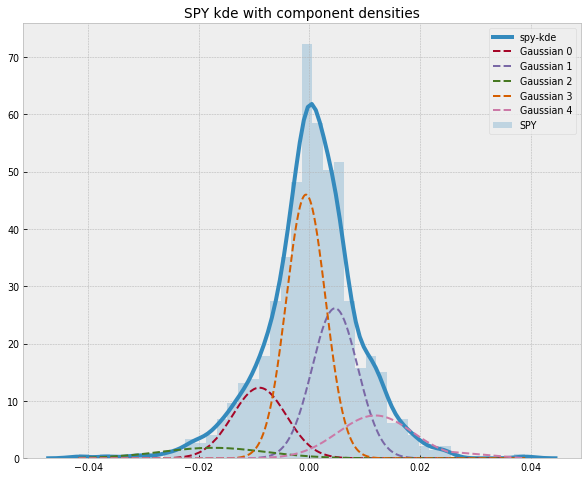

In [55]:
fig, ax = plt.subplots()

# reshape observed returns
x = state_df[sym].sort_values().reshape(-1,1)

# agg pdfs into list
agg_pdfs = [w * stats.norm.pdf(x, mu, sd) 
            for mu, sd, w in zip(gmm.means_, np.sqrt(gmm.covariances_), gmm.weights_)]
# sum density in case
summed_density = np.sum(np.array(agg_pdfs), axis=0)

# plot observed data distribution #and a single component gaussian fit aka norm fit
sns.distplot(x, ax=ax, hist=True, hist_kws=dict(alpha=0.25),
             kde=True, kde_kws=dict(lw=4, label='spy-kde'),
             label=sym)

# plot component gaussians  
for i in range(len(agg_pdfs)): ax.plot(x, agg_pdfs[i], ls='--', label=f'Gaussian {i}');  

# ax.plot(x, summed_density, color='k')  
plt.title(f'{sym} kde with component densities')
plt.legend()

Note the difference between the SPY distribution fit with multiple Gaussians vs below with a single Gaussian fit.

## Conclusions

In this chapter we covered the intuition behind Gaussian Mixture Models (GMM) and how they work. We peeled back the curtain and went through a demonstration of the underlying Expectation-Maximization algorithm that underpins GMMs and many other unsupervised algorithms. From there we used `sklearn` to fit a GMM, and how to make a good choice about the optimal number of components to fit. Finally we demonstrated some of the flexibility and variability of GMMs to fit time-varying distributions.

In the next chapter we will experiment with trading strategy design based on using GMMs to fit distributions. We will evaluate how well the GMM fit across multiple ETFs, and then conducting an event study to analyze if there are any tradeable patterns.